# Feature engineering on extracted Pull Requests data


## What we did previously

In the previous [notebook](./01_data_collection.ipynb) we collected data from a Github repository of choice and store them on S3 storage

## In this step

In this notebook we will walk through how to start analyzing the PR data collected from a Github repository.

We explore the various fields in the PR dataset and the features that we can derive from them in order to frame an a Machine Learning where we predict the time taken to merge a PR.

In [1]:
import os
import re
import gzip
import json
import boto3
import pathlib
import datetime
from tqdm import tqdm
from io import BytesIO
from pathlib import Path
from functools import partial
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif, f_classif

from dotenv import load_dotenv, find_dotenv

In [2]:
class CephCommunication:
    """
    Class to establish communication with a ceph s3 bucket.
    It connects with the bucket and provides methods to read and write data in the parquet format.
    """

    def __init__(
        self, s3_endpoint_url, aws_access_key_id, aws_secret_access_key, s3_bucket
    ):
        self.s3_endpoint_url = s3_endpoint_url
        self.aws_access_key_id = aws_access_key_id
        self.aws_secret_access_key = aws_secret_access_key
        self.s3_resource = boto3.resource(
            "s3",
            endpoint_url=self.s3_endpoint_url,
            aws_access_key_id=self.aws_access_key_id,
            aws_secret_access_key=self.aws_secret_access_key,
        )
        self.bucket = s3_bucket
        ## Todo: Add try catch

    def upload_to_ceph(self, dataframe, s3_path, filename):
        """
        This helper function takes as input the data frame to be uploaded, and the output filename.
        It then saves the data frame in the defined ceph bucket.
        """
        parquet_buffer = BytesIO()
        dataframe.to_parquet(parquet_buffer)
        s3_obj = self.s3_resource.Object(self.bucket, f"{s3_path}/{filename}")
        status = s3_obj.put(Body=parquet_buffer.getvalue())
        return status

    def read_from_ceph(self, s3_path, filename):
        """
        Helper function to read from ceph and see if the saved data is correct.
        """
        buffer = BytesIO()
        s3_object = self.s3_resource.Object(self.bucket, f"{s3_path}/{filename}")
        s3_object.download_fileobj(buffer)
        df_temp = pd.read_parquet(buffer)
        return df_temp


def save_to_disk(dataframe, path, filename):
    """
    Helper function to save the dataframe
    as a parquet file to disk.
    """
    dataset_base_path = Path(path)
    dataset_base_path.mkdir(parents=True, exist_ok=True)
    dataframe.to_parquet(f"{path}/{filename}")
    return True

In [3]:
sns.set(rc={"figure.figsize": (20, 10)})
load_dotenv(find_dotenv(), override=True)

True

In [4]:
## CEPH Bucket variables
## Create a .env file on your local with the correct configs,

ORG = os.getenv("GITHUB_ORG")
REPO = os.getenv("GITHUB_REPO")

## S3 bucket credentials
s3_endpoint_url = os.getenv("S3_ENDPOINT_URL")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")

REMOTE = os.getenv("REMOTE")

s3_input_data_path = os.getenv("CEPH_BUCKET_PREFIX")
local_input_data_path = "../../../data/raw/GitHub/PullRequest.json.gz"
local_output_data_path = "../../../data/processed/github"
RAW_DATA_PATH = os.path.join(
    s3_input_data_path, "srcopsmetrics/bot_knowledge", ORG, REPO, "PullRequest.json"
)

In [5]:
output = []
if REMOTE:
    print("getting dataset from ceph")
    s3 = boto3.resource(
        "s3",
        endpoint_url=s3_endpoint_url,
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
    )
    content = s3.Object(s3_bucket, RAW_DATA_PATH)
    file = content.get()["Body"].read().decode("utf-8")

    prs = json.loads(file)

    for pr in prs.splitlines():
        output.append(json.loads(pr))

else:
    print("getting dataset from local")
    with gzip.open(local_input_data_path, "r") as f:
        prs = json.loads(f.read().decode("utf-8"))

pr_df = pd.DataFrame(output)

getting dataset from ceph


In [6]:
pr_df

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at,id
0,Release of version 2.12.0,"Hey, @xtuchyna!\n\nOpening this PR to create a...",M,khebhut[bot],1665600542,1.665601e+09,sesheta,1.665601e+09,sesheta,1,2,{'sesheta': 327},"{'1139569371': {'author': 'sefkhet-abwy[bot]',...","[approved, bot, size/M, ok-to-test]",[2eadea6d1417c3baede8d3b32ea1cd01c37bb319],"[CHANGELOG.md, srcopsmetrics/__init__.py]",1.665601e+09,1.665601e+09,612
1,Automatic update of dependencies by Kebechet f...,Kebechet has updated the dependencies to the l...,XL,khebhut[bot],1665600524,NaN,None,NaN,None,1,1,"{'sesheta': 187, 'khebhut[bot]': 6}","{'1139569050': {'author': 'sefkhet-abwy[bot]',...","[approved, bot, size/XL, ok-to-test]",[fcd36e9e238c243c73ca0a214ed373b2cf5c1c35],[Pipfile.lock],1.665601e+09,1.665601e+09,611
2,Mi fixes,## Related Issues and Dependencies\r\nrelated ...,L,Gkrumbach07,1663711269,1.665600e+09,sesheta,1.665600e+09,sesheta,8,6,"{'xtuchyna': 13, 'Gkrumbach07': 24, 'sesheta':...","{'1118375791': {'author': 'xtuchyna', 'words_c...","[approved, size/L]","[29f4ffd578ee20ff379765d7835dc5a306832a3c, 98e...","[srcopsmetrics/cli.py, srcopsmetrics/entities/...",1.663938e+09,1.665600e+09,609
3,Automatic update of base-image in CI,Automatic update of base-image in CI.,XS,sesheta,1663342324,1.663345e+09,sesheta,1.663345e+09,sesheta,1,1,{'sesheta': 140},"{'1110874496': {'author': 'sefkhet-abwy[bot]',...","[approved, size/XS, ok-to-test]",[d5d590ff2a244cb4d2baee2682ee9b982b4b5c19],[.aicoe-ci.yaml],1.663342e+09,1.663342e+09,608
4,Automatic update of dependencies by Kebechet f...,Kebechet has updated the dependencies to the l...,L,khebhut[bot],1663342276,1.663344e+09,sesheta,1.663344e+09,sesheta,1,1,{'sesheta': 397},"{'1110873483': {'author': 'sefkhet-abwy[bot]',...","[approved, size/L, bot, ok-to-test]",[a676faae110a141fb409c6d7cd959d364a8cfe50],[Pipfile.lock],1.663342e+09,1.663342e+09,607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,Feature/expand data collection from prs,## Related Issues and Dependencies\r\n\r\n…\r\...,L,xtuchyna,1576000129,1.577178e+09,None,1.577178e+09,None,6,1,"{'pacospace': 1, 'ghost': 50}","{'330365548': {'author': 'pacospace', 'words_c...","[approved, size/L]","[350b1c92016696cd92bccc96bc1dc067494cbd38, cf6...",[create_bot_knowledge.py],1.576054e+09,1.577178e+09,5
412,Correct typo in CODEOWNERS,Signed-off-by: Francesco Murdaca <fmurdaca@red...,XS,pacospace,1574979066,1.575467e+09,goern,1.575467e+09,goern,1,1,{'ghost': 15},"{'324527213': {'author': 'goern', 'words_count...","[approved, size/XS]",[bae7c611679f19b043d29edbc06dfb88b883154a],[.github/CODEOWNERS],1.575005e+09,1.575005e+09,4
413,refactor code and correct the update knowledge...,## Related Issues and Dependencies\r\n\r\n…\r\...,XXL,xtuchyna,1574441228,1.576601e+09,None,1.576601e+09,None,17,5,"{'ghost': 147, 'goern': 16, 'xtuchyna': 26, 'p...","{'324441775': {'author': 'pacospace', 'words_c...","[size/XXL, approved]","[ea1098bcaa5d614ca63f637f6599d3c1f1a40d89, 719...","[.zuul.yaml, create_bot_knowledge.py, pr_revie...",1.574971e+09,1.576055e+09,3
414,Correct update logic,Signed-off-by: Francesco Murdaca <fmurdaca@red...,XS,pacospace,1574357322,1.574437e+09,pacospace,NaN,None,1,1,"{'ghost': 15, 'pacospace': 59}","{'321156268': {'author': 'goern', 'words_count...","[approved, size/XS]",[ddc04fe9f8dccf877afc4d4a5b68c33cedab707b],[create_bot_knowledge.py],1.574367e+09,1.574367e+09,2


In [7]:
pr_df.shape

(416, 19)

In [8]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at,id
0,Release of version 2.12.0,"Hey, @xtuchyna!\n\nOpening this PR to create a...",M,khebhut[bot],1665600542,1.665601e+09,sesheta,1.665601e+09,sesheta,1,2,{'sesheta': 327},"{'1139569371': {'author': 'sefkhet-abwy[bot]',...","[approved, bot, size/M, ok-to-test]",[2eadea6d1417c3baede8d3b32ea1cd01c37bb319],"[CHANGELOG.md, srcopsmetrics/__init__.py]",1.665601e+09,1.665601e+09,612
1,Automatic update of dependencies by Kebechet f...,Kebechet has updated the dependencies to the l...,XL,khebhut[bot],1665600524,NaN,None,NaN,None,1,1,"{'sesheta': 187, 'khebhut[bot]': 6}","{'1139569050': {'author': 'sefkhet-abwy[bot]',...","[approved, bot, size/XL, ok-to-test]",[fcd36e9e238c243c73ca0a214ed373b2cf5c1c35],[Pipfile.lock],1.665601e+09,1.665601e+09,611


## Feature engineering

In the next section we will do some basic feature engineering and correlation analyis on our dataset to see if anything interesting jumps out at us. 

**Time to Merge**

We will derive a new feature called `time_to_merge` which will be the difference between the `created_at` and `merged_at` fields. 

In [9]:
# derive time_to_merege
pr_df["time_to_merge"] = pr_df["merged_at"] - pr_df["created_at"]
pr_df["time_to_merge"] = pr_df["time_to_merge"].astype("float")
# NOTE: we cant fill NA with 0 because that would imply the PR got merged instantaneously

In [10]:
pr_df["time_to_merge"]

0          756.0
1            NaN
2      1888847.0
3         2731.0
4         1340.0
         ...    
411    1177800.0
412     488406.0
413    2159397.0
414          NaN
415        382.0
Name: time_to_merge, Length: 416, dtype: float64

Let's look at the distribution of the time to merge column. This can help us determine what the setup for ML problems such as [#236](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/236) could be like. That is, should the time to merge problem be framed as a regression or classification problem.

First, lets try to determine what the granularity of the output values should be, in case of a regression setup. That is, should the model predict time to merge in number of seconds, number of hours, number of days, or some other chunk of time.

In [11]:
# what does the distribution of values look like if we choose days as the granularity
ttm_days = np.ceil(pr_df.time_to_merge / (60 * 60 * 24))

# value counts - to how many PRs have value 1, 2, 3, etc. for days to merge
vc = ttm_days.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0     0.822917
2.0     0.036458
5.0     0.018229
6.0     0.015625
3.0     0.010417
14.0    0.010417
4.0     0.007812
21.0    0.007812
15.0    0.007812
22.0    0.005208
10.0    0.005208
13.0    0.005208
17.0    0.005208
9.0     0.005208
12.0    0.005208
20.0    0.005208
23.0    0.002604
11.0    0.002604
19.0    0.002604
55.0    0.002604
7.0     0.002604
51.0    0.002604
18.0    0.002604
63.0    0.002604
28.0    0.002604
25.0    0.002604
Name: time_to_merge, dtype: float64

In [12]:
# what if we chose some intermediate value e.g. 3 hours as the granularity?
ttm_3hours = np.ceil(pr_df.time_to_merge / (60 * 60 * 3))

# value counts - to how many PRs have value 1, 2, 3, etc. for num. 3-hours to merge
vc = ttm_3hours.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0      0.731771
2.0      0.028646
8.0      0.018229
5.0      0.013021
7.0      0.013021
6.0      0.010417
9.0      0.010417
40.0     0.010417
41.0     0.007812
16.0     0.007812
11.0     0.005208
31.0     0.005208
96.0     0.005208
20.0     0.005208
3.0      0.005208
153.0    0.005208
71.0     0.005208
15.0     0.005208
46.0     0.005208
14.0     0.002604
137.0    0.002604
29.0     0.002604
12.0     0.002604
105.0    0.002604
407.0    0.002604
136.0    0.002604
80.0     0.002604
21.0     0.002604
74.0     0.002604
104.0    0.002604
45.0     0.002604
19.0     0.002604
222.0    0.002604
33.0     0.002604
176.0    0.002604
110.0    0.002604
109.0    0.002604
439.0    0.002604
4.0      0.002604
118.0    0.002604
167.0    0.002604
149.0    0.002604
161.0    0.002604
113.0    0.002604
120.0    0.002604
34.0     0.002604
106.0    0.002604
10.0     0.002604
130.0    0.002604
166.0    0.002604
39.0     0.002604
184.0    0.002604
175.0    0.002604
504.0    0.002604
87.0     0.002604
56.0     0

In [13]:
# what if we chose hours as the granularity?
ttm_hours = np.ceil(pr_df.time_to_merge / (60 * 60))

# value counts - to how many PRs have value 1, 2, 3, etc. for hours to merge
vc = ttm_hours.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0      0.687500
2.0      0.041667
4.0      0.018229
22.0     0.013021
13.0     0.007812
           ...   
44.0     0.002604
137.0    0.002604
116.0    0.002604
497.0    0.002604
600.0    0.002604
Name: time_to_merge, Length: 82, dtype: float64

Now, lets try to determine, if we were to set this up as a classification problem, what the output classes should be. In the following cell, we'll try to split the time-to-merge values into 10 equally populated buckets.

In [14]:
# lets look at what the 10th, 20th, 30th etc percentiles are, to see what the bin boundaries (in terms of hours)
# would be if we were to split the data in 10 equally populated bins
n_buckets = 10

quantiles = pr_df.time_to_merge.quantile(q=np.arange(0, 1 + 1e-100, 1 / n_buckets))
quantiles / 3600

0.0      0.001944
0.1      0.010361
0.2      0.032944
0.3      0.037778
0.4      0.072278
0.5      0.168750
0.6      0.341278
0.7      1.391222
0.8     19.724167
0.9    120.568972
Name: time_to_merge, dtype: float64

In [15]:
intervals = quantiles

In [16]:
# gaps between the buckets (i.e. size of each bucket) in hours
(quantiles - quantiles.shift()) / 3600

0.0           NaN
0.1      0.008417
0.2      0.022583
0.3      0.004833
0.4      0.034500
0.5      0.096472
0.6      0.172528
0.7      1.049944
0.8     18.332944
0.9    100.844806
Name: time_to_merge, dtype: float64

If we want to frame our ML problem as a classification problem, we can use the above buckets to define the classes.

**Body**

Here, we will derive a feature called `body_size` which will simply be the number of words in the body of the PR. We can use this numerical value to describe the body of the PR.

In [17]:
# derive body_size
pr_df["body_size"] = pr_df["body"].fillna("").apply(lambda x: len(x.split()))

In [18]:
pr_df["body_size"]

0      468
1       74
2      124
3        6
4       73
      ... 
411     83
412     17
413     77
414     61
415     40
Name: body_size, Length: 416, dtype: int64

**Size**

We can attempt to convert the categorical size label generated by GitHub, which summarizes the size of the changes made to the code base, to a numerical value. 

In [19]:
set(pr_df['size'])

{'L', 'M', 'S', 'XL', 'XS', 'XXL'}

In [20]:
convert_size = {"size": {"NaN": 0, "XS": 0, "S": 1, "M": 2, "L": 3, "XL": 4, "XXL": 5}}
pr_df = pr_df.replace(convert_size)

**Title**

Lets try to see if the PR title text can be used to extract any useful information regarding the PR.

In [21]:
# first lets preprocess the text available in the titles

# convert to lowercase
preproc_titles = pr_df["title"].str.lower()

# remove punctuations and symbols like : ; , # ( ) [ ] etc
preproc_titles = preproc_titles.str.replace(r'[`#-.?!,:;\/()\[\]"\']', " ", regex=True)

# remove hash-like strings i.e. 25+ char long strings containing 0-9 or a-f
preproc_titles = preproc_titles.str.replace(r"[0-9a-f]{25,}", " ", regex=True)

preproc_titles

0                              release of version 2 12 0
1      automatic update of dependencies by kebechet f...
2                                               mi fixes
3                   automatic update of base image in ci
4      automatic update of dependencies by kebechet f...
                             ...                        
411              feature expand data collection from prs
412                           correct typo in codeowners
413    refactor code and correct the update knowledge...
414                                 correct update logic
415    collect and analyze stastistics on project rep...
Name: title, Length: 416, dtype: object

In [22]:
# what are the most commonly appearing words in the titles

# combin all titles and split into words
words = preproc_titles.str.cat(sep=" ").split()

# remove stopwords and numbers (e.g. bugzilla ids)
words = [w for w in words if w not in set(STOPWORDS) and not w.isnumeric()]

# word frequencies
unique_words, counts = np.unique(words, return_counts=True)
vc = pd.Series(counts, index=unique_words).sort_values(ascending=False)

From the above graph, we can see that titles often contain some keywords that can hint towards the type of changes being made in the PR. We will create a feature which is a vector indicating how many times each word appeared in the title. This way, even if a less prominent word is more correlated with time_to_merge, we will be able to capture that relationship.

In [23]:
# add word count columns
for word in tqdm(unique_words):
    pr_df[f"title_wordcount_{word}"] = preproc_titles.apply(
        lambda x: x.split().count(word)
    )

  0%|          | 0/328 [00:00<?, ?it/s]/tmp/ipykernel_146/4191214648.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pr_df[f"title_wordcount_{word}"] = preproc_titles.apply(
 30%|██▉       | 97/328 [00:00<00:00, 317.52it/s]/tmp/ipykernel_146/4191214648.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pr_df[f"title_wordcount_{word}"] = preproc_titles.apply(
/tmp/ipykernel_146/4191214648.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

In [24]:
# collapse the high dim vector into one column
wordcount_columns = [c for c in pr_df.columns if "wordcount" in c]
pr_df["title_word_counts_vec"] = pr_df[wordcount_columns].apply(
    lambda x: x.tolist(), axis=1
)

# drop the individual wordcount columns
pr_df = pr_df.drop(columns=wordcount_columns)

**Created At**

This column can give us information on when the PR was created. Using the `created_at` field, we can derive other features like `time_of_day`, `day_of_week`, `day_of_month`, `month_in_year` each of which can be categorical features that can be useful to our analysis.

In [25]:
# convert to datetime object
pr_df["created_at_datetime"] = (
    pr_df["created_at"].fillna("").apply(lambda x: datetime.datetime.fromtimestamp(x))
)
# get day as categorical variable
pr_df["created_at_day"] = pr_df["created_at_datetime"].apply(lambda x: x.day)

# get month as categorical variable
pr_df["created_at_month"] = pr_df["created_at_datetime"].apply(lambda x: x.month)

# get weekday as categorical variable
pr_df["created_at_weekday"] = pr_df["created_at_datetime"].apply(lambda x: x.weekday())

# get hour of day as categorical variable
pr_df["created_at_hour"] = pr_df["created_at_datetime"].apply(lambda x: x.hour)

In [26]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,...,first_approve_at,id,time_to_merge,body_size,title_word_counts_vec,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour
0,Release of version 2.12.0,"Hey, @xtuchyna!\n\nOpening this PR to create a...",2,khebhut[bot],1665600542,1.665601e+09,sesheta,1.665601e+09,sesheta,1,...,1.665601e+09,612,756.0,468,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-10-12 18:49:02,12,10,2,18
1,Automatic update of dependencies by Kebechet f...,Kebechet has updated the dependencies to the l...,4,khebhut[bot],1665600524,NaN,None,NaN,None,1,...,1.665601e+09,611,NaN,74,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-10-12 18:48:44,12,10,2,18


**Changed Files Number**  
Changed files is a numberical variable which captures the numer of files that were modified in the PR.

In [27]:
# convert changed_files_number to int
pr_df["changed_files_number"] = pr_df["changed_files_number"].astype("int")

pr_df.changed_files_number.value_counts()

1     290
2      71
3      11
4       9
6       8
5       6
9       4
8       3
7       3
10      2
11      2
13      2
20      1
15      1
12      1
17      1
35      1
Name: changed_files_number, dtype: int64

`changed_files_number` has more variability than the `commits_number`. We can incorporate this as a numerical feature.

**Changed_files**

`changed_files` is a list of the paths and filenames for every file changed by this PR. From `changed_files`, we know, for each PR, which file types were changed which can be encoded as a frequency vector. Also we know which directory the change is made in, so that can be encoded as a categorical variable.

In [28]:
pr_df.changed_files

0              [CHANGELOG.md, srcopsmetrics/__init__.py]
1                                         [Pipfile.lock]
2      [srcopsmetrics/cli.py, srcopsmetrics/entities/...
3                                       [.aicoe-ci.yaml]
4                                         [Pipfile.lock]
                             ...                        
411                            [create_bot_knowledge.py]
412                                 [.github/CODEOWNERS]
413    [.zuul.yaml, create_bot_knowledge.py, pr_revie...
414                            [create_bot_knowledge.py]
415    [Pipfile, Pipfile.lock, README.md, create_bot_...
Name: changed_files, Length: 416, dtype: object

In [29]:
def filetype(filepath):

    # if standard file extension, return file extension
    if pathlib.Path(filepath).suffix:
        return pathlib.Path(filepath).suffix

    else:
        # if single file at the root of repo
        if "/" not in filepath:
            # if a file like README/Dockerfile etc
            if "." not in filepath:
                return filepath
        # if file not at root
        else:
            # get file name
            file = filepath.rsplit("/", 1)[1]
            if "." not in file:
                return file
            elif "." in file:
                return "." + file.rsplit(".", 1)[1]

In [30]:
# get list of all file types that were modified across all openshift origin PRs
changed_files = list(pr_df["changed_files"])

In [31]:
all_changed_files = [filetype(filepath) for pr in changed_files for filepath in pr]

In [32]:
count = Counter(all_changed_files)

In [33]:
# save 100 most commonly occuring file extensions across PRs
top_fileextensions_freq = count.most_common(100)
top_fileextensions = [ext[0] for ext in top_fileextensions_freq]

In [34]:
top_fileextensions

['.py',
 '.lock',
 '.md',
 '.yaml',
 'Pipfile',
 '.rst',
 'OWNERS',
 '.toml',
 'CODEOWNERS',
 None,
 '.png',
 '.txt',
 'mi-scheduler']

In [35]:
def file_type_freq(list_of_filepaths):
    """
    For a given PR's list of changed files,
    return a changed files frequency vector
    ( a vector which holds the frequency of
    changed files of the type  for every
    file type in top_fileextensions )
    """

    file_extensions = [filetype(f) for f in list_of_filepaths]
    ext_dict = {key: 0 for key in top_fileextensions}
    for f in file_extensions:
        if f in ext_dict:
            ext_dict[f] += 1

    return list(ext_dict.values())

In [36]:
pr_df["changed_file_type_vec"] = pr_df["changed_files"].apply(
    lambda x: file_type_freq(x)
)

In [37]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,...,id,time_to_merge,body_size,title_word_counts_vec,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_file_type_vec
0,Release of version 2.12.0,"Hey, @xtuchyna!\n\nOpening this PR to create a...",2,khebhut[bot],1665600542,1.665601e+09,sesheta,1.665601e+09,sesheta,1,...,612,756.0,468,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-10-12 18:49:02,12,10,2,18,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,Automatic update of dependencies by Kebechet f...,Kebechet has updated the dependencies to the l...,4,khebhut[bot],1665600524,NaN,None,NaN,None,1,...,611,NaN,74,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-10-12 18:48:44,12,10,2,18,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


## Create PR trends dashboard

## Infer dataframe columns as Features

We can see above that some PRs have 0 for all directory fields since the directory structure of the repo has changed over time and we are interested in only the latest directory structure.

In [38]:
# subset DataFrame to use as features
feature_df = pr_df[
    [
        "time_to_merge",
        "changed_files_number",
        "body_size",
        "size",
        "title_word_counts_vec",
        "created_at_day",
        "created_at_month",
        "created_at_weekday",
        "created_at_hour",
        "commits_number",
        "changed_file_type_vec",
    ]
]

### Add PR TTM Class Column 

Lets split up the time to merge values into 10 discrete bins (as discussed above) to use as our prediction classes.

In [39]:
intervals

0.0         7.0
0.1        37.3
0.2       118.6
0.3       136.0
0.4       260.2
0.5       607.5
0.6      1228.6
0.7      5008.4
0.8     71007.0
0.9    434048.3
Name: time_to_merge, dtype: float64

In [40]:
def get_ttm_class(ttm):

    for rownum, (indx, val) in enumerate(intervals.iteritems()):
        if ttm < val:
            return rownum - 1
    return 9


feature_df["ttm_class"] = (feature_df["time_to_merge"]).apply(get_ttm_class)
feature_df.head()

/tmp/ipykernel_146/2436122750.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df["ttm_class"] = (feature_df["time_to_merge"]).apply(get_ttm_class)


,time_to_merge,changed_files_number,body_size,size,title_word_counts_vec,created_at_day,created_at_month,created_at_weekday,created_at_hour,commits_number,changed_file_type_vec,ttm_class
0,756.0,2,468,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12,10,2,18,1,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5
1,NaN,1,74,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12,10,2,18,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",9
2,1888847.0,6,124,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20,9,1,22,8,"[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",9
3,2731.0,1,6,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",16,9,4,15,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",6
4,1340.0,1,73,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",16,9,4,15,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",6


## Evaluating Feature Importances

### Categorical Features

First, lets try to determine what categorical featuers are powerful influencers for time to merge of a PR

In [41]:
# feature selection helper function
def select_features(x, y, func):
    fs = SelectKBest(score_func=func, k="all")
    fs.fit(x, y)
    x_fs = fs.transform(x)
    return x_fs, fs


selected_features = []

In [42]:
cat_features = [
    "size",
    "created_at_day",
    "created_at_month",
    "created_at_weekday",
    "created_at_hour",
    "ttm_class",
]

In [43]:
cat_df = feature_df[cat_features]

cat_df.head()

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,ttm_class
0,2,12,10,2,18,5
1,4,12,10,2,18,9
2,3,20,9,1,22,9
3,0,16,9,4,15,6
4,3,16,9,4,15,6


In [44]:
# split into input (x) and output (y) variables
X_inp = cat_df.drop(columns=["ttm_class"])
y = cat_df["ttm_class"]

In [45]:
# rank using mutual_info_classif
X_fs, fs = select_features(X_inp, y, mutual_info_classif)

In [46]:
for i in range(len(fs.scores_)):
    print("Feature %s: %f" % (X_inp.columns[i], fs.scores_[i]))

Feature size: 0.108746
Feature created_at_day: 0.206146
Feature created_at_month: 0.309708
Feature created_at_weekday: 0.018492
Feature created_at_hour: 0.116922


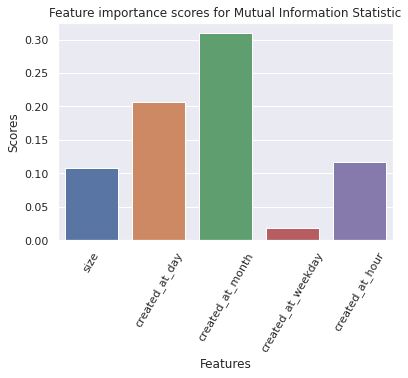

In [47]:
# visualize scores of all features
sns.barplot(x=X_inp.columns, y=fs.scores_)
plt.title("Feature importance scores for Mutual Information Statistic")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

In [48]:
# Lets get a list of the top 10 feature indices based on Mutual Info Stat feature scores
top_mis = fs.scores_.argsort()[-10:][::-1]

In [49]:
# rank using chi_sq
X_fs, fs = select_features(X_inp, y, chi2)

In [50]:
for i in range(len(fs.scores_)):
    print("Feature %s: %f" % (X_inp.columns[i], fs.scores_[i]))

Feature size: 65.361113
Feature created_at_day: 47.122135
Feature created_at_month: 177.406687
Feature created_at_weekday: 17.292034
Feature created_at_hour: 33.252314


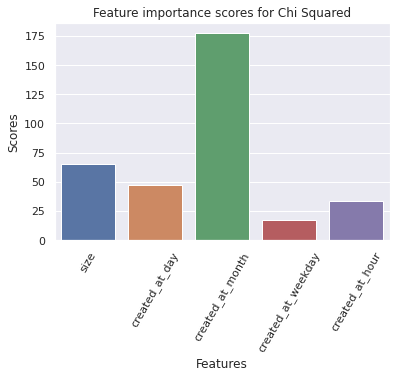

In [51]:
# visualize scores of all features
sns.barplot(x=X_inp.columns, y=fs.scores_)
plt.title("Feature importance scores for Chi Squared")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

In [52]:
# Lets get a list of the top 10 feature indices based on Chi Sq feature scores
top_chi2 = fs.scores_.argsort()[-10:][::-1]

Let's get a Union of the top 10 features derived from features based on both scores of both Mutual Info Statistic and Chi Squared

In [53]:
union = set(top_mis).union(set(top_chi2))
print(len(union))
union

5


{0, 1, 2, 3, 4}

In [54]:
selected_cat_features = [cat_features[i] for i in union]
selected_cat_features

['size',
 'created_at_day',
 'created_at_month',
 'created_at_weekday',
 'created_at_hour']

In [55]:
# update list of features to keep for training
selected_features += selected_cat_features

### Numerical Features

Now, lets try to determine what numerical featuers are powerful influencers for time to merge of a PR

In [56]:
numerical_features = [
    "changed_files_number",
    "body_size",
    "commits_number",
    "ttm_class",
]

In [57]:
numerical_df = feature_df[numerical_features]
numerical_df.head()

,changed_files_number,body_size,commits_number,ttm_class
0,2,468,1,5
1,1,74,1,9
2,6,124,8,9
3,1,6,1,6
4,1,73,1,6


In [58]:
# split into input features and target
X_inp = numerical_df.drop(columns=["ttm_class"])
y = numerical_df["ttm_class"]

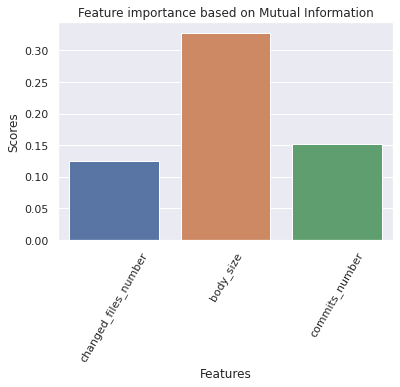

In [59]:
# create k best feature selector object based on mutual information
numerical_feats_mi, k_best_selector_mi = select_features(
    X_inp,
    y,
    partial(
        mutual_info_classif,
        discrete_features=False,
        random_state=42,
        n_neighbors=3,
    ),
)

# visualize the MI scores of all features
sns.barplot(x=X_inp.columns, y=k_best_selector_mi.scores_)
plt.title("Feature importance based on Mutual Information")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

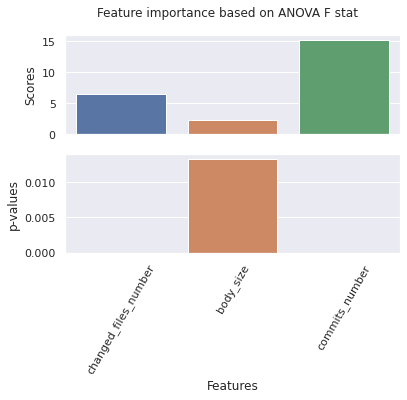

In [60]:
# create k best feature selector object based on anova f statistic
numerical_feats_f, k_best_selector_f = select_features(
    X_inp,
    y,
    f_classif,
)

# visualize the f stat scores and pvalues of all features
fig, axes = plt.subplots(2, 1, sharex=True)
fig.suptitle("Feature importance based on ANOVA F stat")
sns.barplot(x=X_inp.columns, y=k_best_selector_f.scores_, ax=axes[0])
sns.barplot(x=X_inp.columns, y=k_best_selector_f.pvalues_, ax=axes[1])
plt.xticks(rotation=60)
plt.xlabel("Features")
axes[0].set_ylabel("Scores")
axes[1].set_ylabel("p-values")
plt.show()

In [61]:
top_mi = k_best_selector_mi.scores_.argsort()[-3:][::-1]
top_anova = k_best_selector_f.scores_.argsort()[-3:][::-1]
union = set(top_mi).union(set(top_anova))
union

{0, 1, 2}

In [62]:
selected_num_features = [numerical_features[i] for i in union]
selected_num_features

['changed_files_number', 'body_size', 'commits_number']

In [63]:
# update list of features to keep for training
selected_features += selected_num_features

### Count Vector Type Features

Finally, lets determine the most important features from the count vector type columns.

In [64]:
# explode the list column so that there is 1 column representing frequency of each file type
filetype_df = pd.DataFrame(feature_df.changed_file_type_vec.to_list())
filetype_df.index = feature_df.index
filetype_df.columns = [f"filetype_{f}" for f in top_fileextensions]

In [65]:
# compute correlation with ttm
corr = filetype_df.corrwith(feature_df["ttm_class"])
corr.sort_values(ascending=False)

filetype_.py             0.378647
filetype_Pipfile         0.208348
filetype_.rst            0.206917
filetype_.yaml           0.164107
filetype_CODEOWNERS      0.127641
filetype_OWNERS          0.099735
filetype_.toml           0.094884
filetype_mi-scheduler    0.067669
filetype_.png            0.067669
filetype_None            0.062127
filetype_.txt            0.051350
filetype_.md            -0.002293
filetype_.lock          -0.405104
dtype: float64

In [66]:
corr[corr.abs() > 0.01]

filetype_.py             0.378647
filetype_.lock          -0.405104
filetype_.yaml           0.164107
filetype_Pipfile         0.208348
filetype_.rst            0.206917
filetype_OWNERS          0.099735
filetype_.toml           0.094884
filetype_CODEOWNERS      0.127641
filetype_None            0.062127
filetype_.png            0.067669
filetype_.txt            0.051350
filetype_mi-scheduler    0.067669
dtype: float64

In [67]:
# update list of features to keep for training
# take everything that has more than 0.01 correlation magnitude
filetype_keep_cols = corr[corr.abs() > 0.01].index.tolist()
selected_features += filetype_keep_cols

# only keep the relevant columns now
filetype_df = filetype_df[filetype_keep_cols]

In [68]:
filetype_keep_cols = [i[9:] for i in filetype_keep_cols]
filetype_keep_cols

['.py',
 '.lock',
 '.yaml',
 'Pipfile',
 '.rst',
 'OWNERS',
 '.toml',
 'CODEOWNERS',
 'None',
 '.png',
 '.txt',
 'mi-scheduler']

In [69]:
filetype_keep_cols_df = pd.DataFrame(filetype_keep_cols, columns=["filetype"])

In [70]:
filetype_keep_cols_df

,filetype
0,.py
1,.lock
2,.yaml
3,Pipfile
4,.rst
5,OWNERS
6,.toml
7,CODEOWNERS
8,None
9,.png


In [71]:
FILETYPE_FEATURES_FILENAME = os.path.join(ORG + REPO + "FILETYPE.parquet")
FILETYPE_FEATURES_KEY = os.path.join(s3_input_data_path, ORG, REPO, "features")
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
cc.upload_to_ceph(
    filetype_keep_cols_df, FILETYPE_FEATURES_KEY, FILETYPE_FEATURES_FILENAME
)

{'ResponseMetadata': {'RequestId': 'la2bibxr-3r4ng2-2ku',
  'HostId': 'la2bibxr-3r4ng2-2ku',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-request-id': 'la2bibxr-3r4ng2-2ku',
   'x-amz-id-2': 'la2bibxr-3r4ng2-2ku',
   'access-control-allow-origin': '*',
   'access-control-allow-credentials': 'true',
   'access-control-allow-methods': 'GET,POST,PUT,DELETE,OPTIONS',
   'access-control-allow-headers': 'Content-Type,Content-MD5,Authorization,X-Amz-User-Agent,X-Amz-Date,ETag,X-Amz-Content-Sha256',
   'access-control-expose-headers': 'ETag,X-Amz-Version-Id',
   'etag': '"874bbcf5710f45d0c4537d31cc73d2af"',
   'date': 'Fri, 04 Nov 2022 09:52:13 GMT',
   'keep-alive': 'timeout=5',
   'content-length': '0',
   'set-cookie': '1a4aa612fe797ac8466d7ee00e5520d5=a26d7dd2bae782e2ad6181b7887b5ff1; path=/; HttpOnly; Secure; SameSite=None'},
  'RetryAttempts': 0},
 'ETag': '"874bbcf5710f45d0c4537d31cc73d2af"'}

In [72]:
# explode the list column so that there is 1 column representing frequency of each word
title_wordcount_df = pd.DataFrame(feature_df.title_word_counts_vec.to_list())

title_wordcount_df.index = feature_df.index
title_wordcount_df.columns = [f"title_wordcount_{w}" for w in unique_words]

In [73]:
# compute correlation with ttm
corr = title_wordcount_df.corrwith(feature_df["ttm_class"])
corr = corr.dropna()
corr.sort_values(ascending=False)

title_wordcount_feature       0.295952
title_wordcount_add           0.225819
title_wordcount_readme        0.182360
title_wordcount_fix           0.170591
title_wordcount_bump          0.167918
                                ...   
title_wordcount_dash         -0.265476
title_wordcount_storages     -0.275256
title_wordcount_update       -0.470282
title_wordcount_automatic    -0.537306
title_wordcount_dependency   -0.577051
Length: 328, dtype: float64

In [74]:
corr[corr.abs() > 0.04]

title_wordcount_0rc1        -0.080847
title_wordcount_0rc2        -0.043068
title_wordcount_0rc3        -0.054378
title_wordcount_add          0.225819
title_wordcount_added        0.067669
                               ...   
title_wordcount_wip          0.067669
title_wordcount_workflows    0.067669
title_wordcount_xtuchyna     0.067669
title_wordcount_yaml         0.061154
title_wordcount_⬆️           0.095814
Length: 202, dtype: float64

In [75]:
# update list of features to keep for training
# take everything that has more than 0.01 correlation magnitude
title_word_keep_cols = corr[corr.abs() > 0.04].index.tolist()
selected_features += title_word_keep_cols

title_wordcount_df = title_wordcount_df[title_word_keep_cols]

In [76]:
title_word_keep_cols = [i[16:] for i in title_word_keep_cols]
title_word_keep_cols

['0rc1',
 '0rc2',
 '0rc3',
 'add',
 'added',
 'advise',
 'aggregation',
 'allow',
 'analysis',
 'api',
 'approvers',
 'argo',
 'assignees',
 'atomic',
 'atpi',
 'author',
 'automatic',
 'autopep8',
 'baseentity',
 'basic',
 'bleach',
 'bug',
 'building',
 'bump',
 'ceph',
 'change',
 'check',
 'christoph',
 'class',
 'clear',
 'cli',
 'coala',
 'code',
 'codeowners',
 'collection',
 'commit',
 'commmit',
 'concept',
 'config',
 'content',
 'contentfile',
 'context',
 'correct',
 'cov',
 'cronjob',
 'cryptography',
 'csv',
 'current',
 'daily',
 'dash',
 'data',
 'dataframes',
 'day',
 'dependencies',
 'dependency',
 'divide',
 'documentation',
 'entities',
 'entity',
 'enttiy',
 'env',
 'environment',
 'envvar',
 'envvars',
 'errors',
 'even',
 'example',
 'excluded',
 'exists',
 'expand',
 'feature',
 'file',
 'files',
 'fix',
 'fixes',
 'functionality',
 'general',
 'gitpython',
 'given',
 'history',
 'identified',
 'impl',
 'implement',
 'implementation',
 'inconsistent',
 'indicato

In [77]:
title_word_keep_cols_df = pd.DataFrame(title_word_keep_cols, columns=["title"])

In [78]:
title_word_keep_cols_df

,title
0,0rc1
1,0rc2
2,0rc3
3,add
4,added
...,...
197,wip
198,workflows
199,xtuchyna
200,yaml


In [79]:
TITLE_FEATURES_FILENAME = os.path.join(ORG + REPO + "titlewords.parquet")
TITLE_FEATURES_KEY = os.path.join(s3_input_data_path, ORG, REPO, "features")
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
cc.upload_to_ceph(title_word_keep_cols_df, TITLE_FEATURES_KEY, TITLE_FEATURES_FILENAME)

{'ResponseMetadata': {'RequestId': 'la2bicpn-3ta3lp-8ik',
  'HostId': 'la2bicpn-3ta3lp-8ik',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-request-id': 'la2bicpn-3ta3lp-8ik',
   'x-amz-id-2': 'la2bicpn-3ta3lp-8ik',
   'access-control-allow-origin': '*',
   'access-control-allow-credentials': 'true',
   'access-control-allow-methods': 'GET,POST,PUT,DELETE,OPTIONS',
   'access-control-allow-headers': 'Content-Type,Content-MD5,Authorization,X-Amz-User-Agent,X-Amz-Date,ETag,X-Amz-Content-Sha256',
   'access-control-expose-headers': 'ETag,X-Amz-Version-Id',
   'etag': '"5379cfcec53dfdf96f3ff50edb6987bd"',
   'date': 'Fri, 04 Nov 2022 09:52:13 GMT',
   'keep-alive': 'timeout=5',
   'content-length': '0',
   'set-cookie': '1a4aa612fe797ac8466d7ee00e5520d5=a26d7dd2bae782e2ad6181b7887b5ff1; path=/; HttpOnly; Secure; SameSite=None'},
  'RetryAttempts': 0},
 'ETag': '"5379cfcec53dfdf96f3ff50edb6987bd"'}

Using various feature importance scores such as chi-squared, mutual information statistic, correlation values, we have selected the most relevant features amongst all of our features. 

In [80]:
selected_features

['size',
 'created_at_day',
 'created_at_month',
 'created_at_weekday',
 'created_at_hour',
 'changed_files_number',
 'body_size',
 'commits_number',
 'filetype_.py',
 'filetype_.lock',
 'filetype_.yaml',
 'filetype_Pipfile',
 'filetype_.rst',
 'filetype_OWNERS',
 'filetype_.toml',
 'filetype_CODEOWNERS',
 'filetype_None',
 'filetype_.png',
 'filetype_.txt',
 'filetype_mi-scheduler',
 'title_wordcount_0rc1',
 'title_wordcount_0rc2',
 'title_wordcount_0rc3',
 'title_wordcount_add',
 'title_wordcount_added',
 'title_wordcount_advise',
 'title_wordcount_aggregation',
 'title_wordcount_allow',
 'title_wordcount_analysis',
 'title_wordcount_api',
 'title_wordcount_approvers',
 'title_wordcount_argo',
 'title_wordcount_assignees',
 'title_wordcount_atomic',
 'title_wordcount_atpi',
 'title_wordcount_author',
 'title_wordcount_automatic',
 'title_wordcount_autopep8',
 'title_wordcount_baseentity',
 'title_wordcount_basic',
 'title_wordcount_bleach',
 'title_wordcount_bug',
 'title_wordcount_b

## Save Feature Engineered Dataset

In [81]:
# join all types of features
ttm_dataset = pd.concat(
    [feature_df, filetype_df, title_wordcount_df], axis=1, ignore_index=False
)

# keep only the selected features and the prediction label
ttm_dataset = ttm_dataset[selected_features + ["ttm_class", "time_to_merge"]]

ttm_dataset.head()

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_files_number,body_size,commits_number,filetype_.py,filetype_.lock,...,title_wordcount_visualization,title_wordcount_visualizations,title_wordcount_waiting,title_wordcount_wip,title_wordcount_workflows,title_wordcount_xtuchyna,title_wordcount_yaml,title_wordcount_⬆️,ttm_class,time_to_merge
0,2,12,10,2,18,2,468,1,1,0,...,0,0,0,0,0,0,0,0,5,756.0
1,4,12,10,2,18,1,74,1,0,1,...,0,0,0,0,0,0,0,0,9,NaN
2,3,20,9,1,22,6,124,8,6,0,...,0,0,0,0,0,0,0,0,9,1888847.0
3,0,16,9,4,15,1,6,1,0,0,...,0,0,0,0,0,0,0,0,6,2731.0
4,3,16,9,4,15,1,73,1,0,1,...,0,0,0,0,0,0,0,0,6,1340.0


In [82]:
ttm_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Columns: 224 entries, size to time_to_merge
dtypes: float64(1), int64(223)
memory usage: 728.1 KB


## Save results to Ceph or locally

Using the helper function to save the data frame in a parquet format on the Ceph bucket if we are running in automation, and locally if not.

In [83]:
TTM_DATASET_PATH = os.path.join(s3_input_data_path, ORG, REPO)

In [84]:
## Sanity check to see if the dataset is the same

if REMOTE:
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    try:
        cc.upload_to_ceph(
            ttm_dataset,
            TTM_DATASET_PATH,
            "ttm_feature_engineered_dataset.parquet",
        )
    except ValueError as ve:
        print(ve)
        print("Files already uploaded to S3")

else:
    save_to_disk(
        ttm_dataset,
        local_output_data_path,
        "ttm_dataset.parquet",
    )

### Check contents of the S3 bucket so far

In [85]:
# check all raw data files in s3
bucket = cc.s3_resource.Bucket(s3_bucket)
objects = [i for i in bucket.objects.all() if s3_input_data_path + "/" in i.key]
sorted(objects, key=lambda x: x.key)

[s3.ObjectSummary(bucket_name='opf-datacatalog', key='nov4/srcopsmetrics/bot_knowledge/thoth-station/mi/PullRequest.json'),
 s3.ObjectSummary(bucket_name='opf-datacatalog', key='nov4/thoth-station/mi/features/thoth-stationmiFILETYPE.parquet'),
 s3.ObjectSummary(bucket_name='opf-datacatalog', key='nov4/thoth-station/mi/features/thoth-stationmititlewords.parquet'),
 s3.ObjectSummary(bucket_name='opf-datacatalog', key='nov4/thoth-station/mi/ttm_feature_engineered_dataset.parquet')]

# Conclusion

This notebook walked through how to access saved raw Pull Requests data from the previous data collection notebook and we engineered some possible features which can be used to predict time to merge of a PR. 

The features we engineered are as following:

- time_to_merge: time taken to merge a PR in seconds, this is feature we will try to predict
- changed_files_number: integer indicating the number of files changed, this is an available column
- body_size: integer indicating the number of words in the body of the PR, derived from body
- size: integer corresponding to a categorical label generated by GitHub which summarizes the size of the changes made to the code base 
- title_word_counts_vec: vector or list indicating how many times each word appeared in the title
- created_at_day: categorical variable indicating the day of month the PR has been created, derived from created_at
- created_at_month: categorical variable indicating the month of the year that the PR has been created, derived from created_at
- created_at_weekday: categorical variable indicating the day of the week the PR has been created, derived from created_at
- created_at_hour: categorical variable indicating the hour of the day the PR has been created, derived from created_at
- commits_number: integer indicating the number of commits in the PR
- changed_file_type_vec:  vector or list consisting of number of files changed for the top 100 most frequently occurring data types, derived from changed_files


# Next Step

In the next [notebook](./03_model_training.ipynb), we will train a classifier to predict time to merge of a PR using the features.